In [29]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import os
import glob
from datetime import datetime
import seaborn as sns


TODO
      - Result val? Dict -> "Numerical CT val if detected"
      - Drop tempstrip_status != Ok ?? ('Frozen' and 'Not Used' have flu-positive participants)
      

Participants were prompted to complete their at-home kit if they reported experiencing symptom
severity of greater than 0 for “Cough”, and greater than 0 for one of the four systemic symptoms
“Body/Muscle aches”/”Feeling feverish”/”Chills or shivering”/”Sweats”

In [2]:
path_root = os.getcwd()+"/gates/raw/audere/data-export/2020-07-15/mtl"

path_results = glob.glob(path_root+"/mtl_lab_order_results/*.parquet")
path_updates = glob.glob(path_root+"/mtl_lab_order_updates/*.parquet")

#os.listdir(root_path)

In [3]:
df_results = pq.read_table(path_results[0]).to_pandas()
df_updates = pq.read_table(path_updates[0]).to_pandas()

In [4]:
pd.set_option("display.max.columns", None)

df_results.describe(include=np.object)

,participant_id,report_sent_datetime,tempstrip_status,test_id,test_name,result,snp,result_value,assay_datetime,event_date
count,2966,2940,2937,2940,2940,2940,0,2883,2889,2940
unique,1006,971,4,3,3,3,0,136,963,38
top,517fe066229f8b4ebfd0c78b2e73a00f,2020-05-15T02:46:17.687Z,Ok,296.0,Respiratory Syncytial Virus (RSV),Not Detected,NaN,-,2020-04-08T21:54:34.000Z,2020-05-22
freq,3,6,2016,980,980,2710,NaN,2654,3,312


In [5]:
#Drop participants with all columns as 'none'  (26 entries) and the non-informative 'snp', redundant evidation generated 'event date',
# redundant 'test_id' column

df_results = df_results.loc[~df_results.test_id.isnull()]
df_results = df_results.drop(columns = ['snp','event_date','test_id'],axis=1)
df_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2940 entries, 0 to 2939
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   participant_id        2940 non-null   object
 1   report_sent_datetime  2940 non-null   object
 2   tempstrip_status      2937 non-null   object
 3   test_name             2940 non-null   object
 4   result                2940 non-null   object
 5   result_value          2883 non-null   object
 6   assay_datetime        2889 non-null   object
dtypes: object(7)
memory usage: 183.8+ KB


In [6]:
#A heavier, B cannot cause pandemics with symptoms likely less severe. RSV is a cold virus, essentialy dangerous to children, very old and 
df_results.loc[(df_results.result == "Detected")].test_name.value_counts()

Influenza A (Flu A)                  149
Influenza B (Flu B)                   57
Respiratory Syncytial Virus (RSV)     21
Name: test_name, dtype: int64

In [7]:
#(positive ratio similar in each group)
df_results.tempstrip_status.value_counts()

Ok                              2016
Frozen                           768
Not Used (no tag in the kit)     117
Overheated                        36
Name: tempstrip_status, dtype: int64

In [13]:
df_updates['shipped_datetime'] = pd.to_datetime(df_updates.shipped_datetime)

df_updates['received_datetime'] = pd.to_datetime(df_updates.received_datetime)
df_updates['report_sent_datetime'] = pd.to_datetime(df_updates.report_sent_datetime)


df_updates.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7308 entries, 0 to 7307
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   participant_id        7308 non-null   object             
 1   type                  7308 non-null   object             
 2   shipped_datetime      5249 non-null   datetime64[ns, UTC]
 3   received_datetime     1043 non-null   datetime64[ns, UTC]
 4   rejected_datetime     7 non-null      object             
 5   rejected_reason       7 non-null      object             
 6   rejected_recoverable  7 non-null      object             
 7   report_sent_datetime  1009 non-null   datetime64[ns, UTC]
 8   event_date            7308 non-null   object             
dtypes: datetime64[ns, UTC](3), object(6)
memory usage: 514.0+ KB


In [14]:
(df_updates.groupby('participant_id')['report_sent_datetime'].max() - df_updates.groupby('participant_id')['received_datetime'].max()).mean()

Timedelta('42 days 02:55:46.583091182')

In [15]:
df_updates.loc[(~df_updates['report_sent_datetime'].isnull())].describe()

df_updates.to_csv('lab_updates.csv')

<ipython-input-15-f61ebc63babd>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_updates.loc[(~df_updates['report_sent_datetime'].isnull())].describe()


In [14]:
df_trigger_lab = pd.read_csv('gates_data_csv/lab_results_with_triggerdate.csv')
df_trigger_lab['trigger_datetime'] = pd.to_datetime(df_trigger_lab.trigger_datetime)

In [28]:
df_trigger_lab.drop_duplicates('participant_id').trigger_datetime.dt.date.plot.hist()

TypeError: no numeric data to plot

<AxesSubplot:>

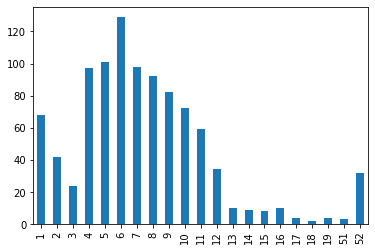

In [55]:
# week 4 - week 11 peak for lab tests
df_trigger_lab.drop_duplicates('participant_id').trigger_datetime.dt.isocalendar().week .value_counts().sort_index( ).plot.bar()

<AxesSubplot:>

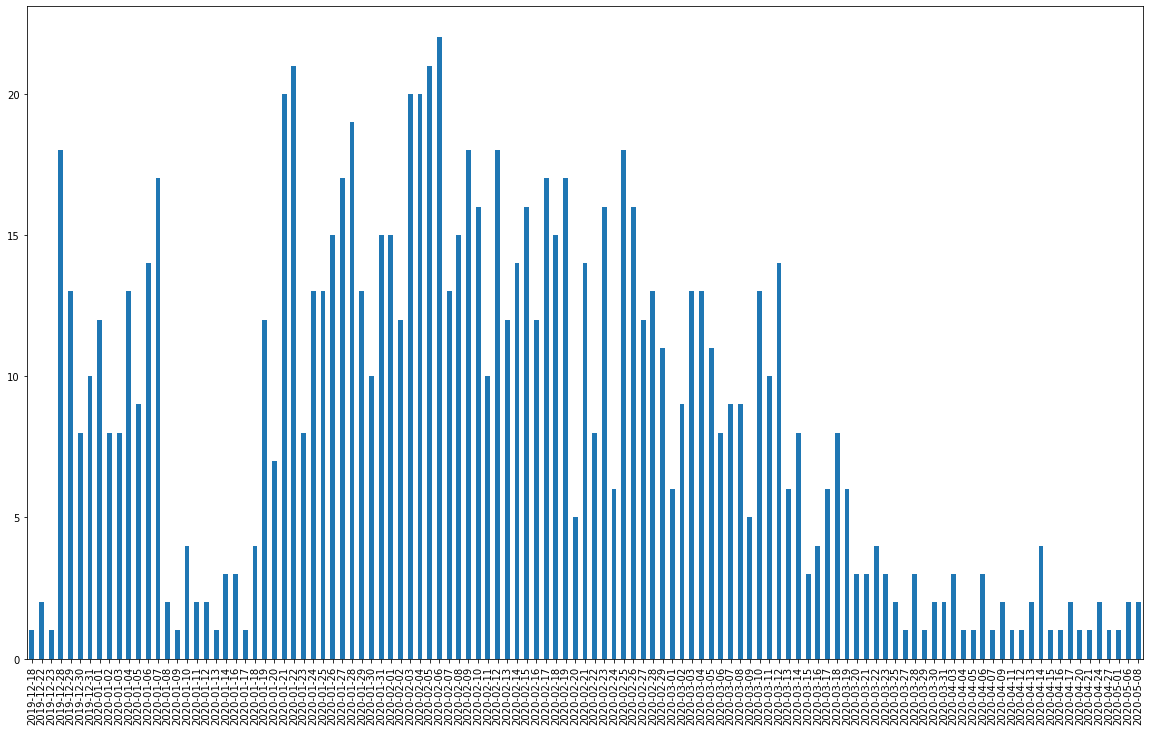

In [59]:
df_trigger_lab.drop_duplicates('participant_id').trigger_datetime.dt.date.value_counts().sort_index( ).plot.bar(figsize=(20,12))

<AxesSubplot:>

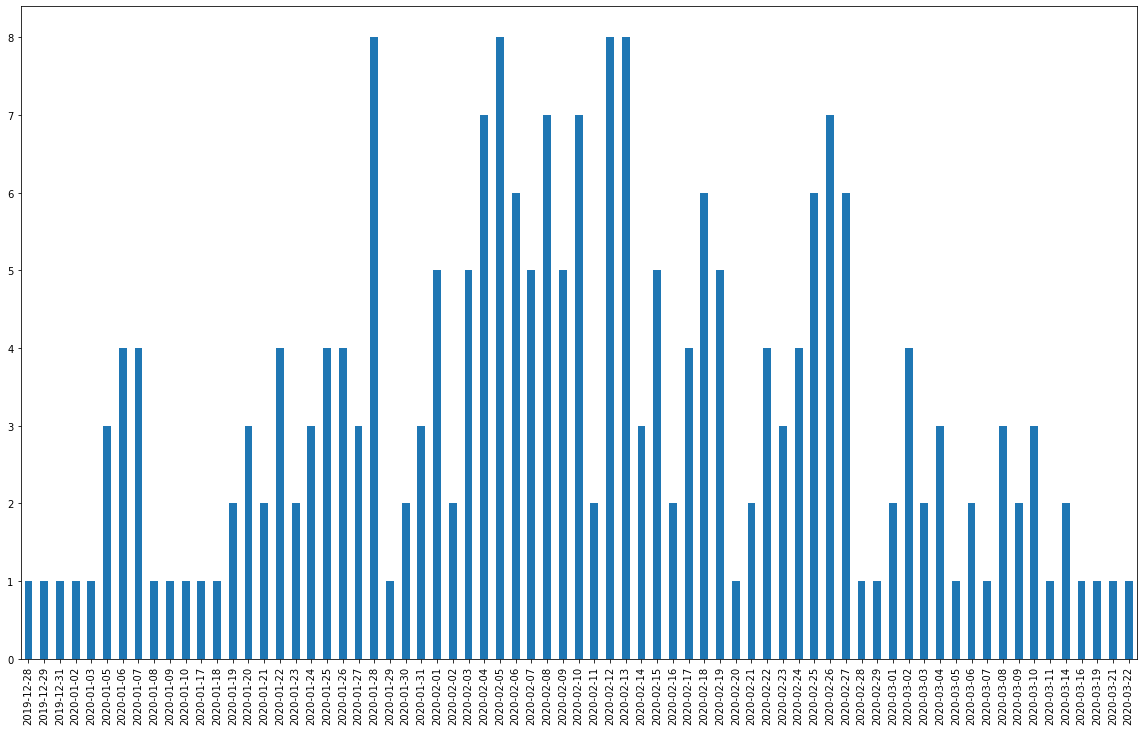

In [58]:
# week 4 - week 9 peak for flu positives
df_trigger_lab.loc[df_trigger_lab.result == 'Detected'].trigger_datetime.dt.date.value_counts().sort_index( ).plot.bar(figsize=(20,12))


<AxesSubplot:>

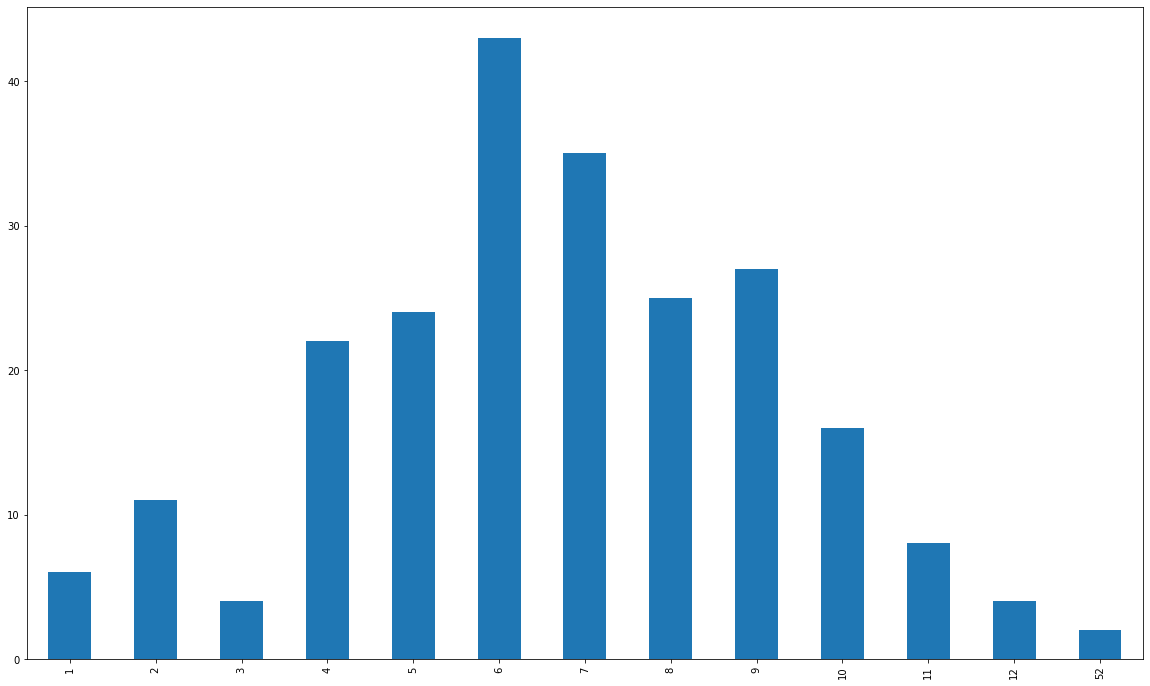

In [60]:
df_trigger_lab.loc[df_trigger_lab.result == 'Detected'].trigger_datetime.dt.isocalendar().week.value_counts().sort_index( ).plot.bar(figsize=(20,12))

